# Estacionaridade 

## Estacionaridade no sentido amplo

## Estacionaridade no sentido estrito

# Autocorrelação

A autocorrelação analisa os dados da série temporal para identificar se existe correlação entre pontos em posições diferentes dentro da série. Para uma mesma variável aleatória verifica-se como os valores da VA se comportam em diferentes instantes de tempo(no caso do índice ser o tempo) e se existe alguma correlação entre eles através do grau de correlação.

# Ergodicidade

Um processo ergódico é aquele em que suas propriedades estatísticas podem ser obtidas através de uma única realização ao longo do tempo. Se calcularmos a média de cada realização ao longo do tempo e a média dos valores entre as realizações((), (),...,()) verificaremos que as médias temporais $ 𝑋𝜉_1𝑡1 𝑋𝜉_2𝑡1 𝑋𝜉_𝑛𝑡1 $ convergem para a média entre as realizações.

# Sazonalidade

A sazonalidade refere-se a flutuações periódicas e previsíveis que ocorrem em intervalos de tempo fixos e conhecidos. É um componente fundamental na análise de séries temporais, que são coleções de observações feitas sequencialmente ao longo do tempo. Essas repetições causadas pela sazonalidade podem representar efeitos sazonais de eventos do mundo real como, por exemplo, a relação das estações dos anos nas temperaturas diárias.
A presença de sazonalidade nos ajuda a identificar outras características do processo estocástico. É possível perceber a presença de sazonalidade visualmente com a distribuição dos dados ou usando ferramentas de análise.

# Dataset

In [2]:
# --- Imports
import os
from pathlib import Path
import seaborn as sns
from scipy import stats


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot

In [3]:


# Optional irsdk (for .ibt)
try:
    import irsdk
    IRSDK_AVAILABLE = True
except Exception:
    IRSDK_AVAILABLE = False

print(f"irsdk available   : {IRSDK_AVAILABLE}")

# --- Paths & Parameters
USE_IBT = True  # set True to read a .ibt with irsdk if available

# --- Configuration ---
COL_TIME = 'SessionTime'      
COL_LAP = 'Lap'              
COL_VAR = 'Throttle_Pct'  

# Core pipeline settings
N_SECTORS = 4               # number of sectors to split the track
BASE_GRID_LEN = 1000
TOPK_PERCENT = 0.30          # robust sector reference: median of fastest top K%
PACE_THRESHOLD_MS = 3000.0   # drop laps whose sum of positive sector losses > 2s
CLIP_MS = 1500.0             # clip training target (ms)
SEQ_LEN = 128                # per-sector resampling for stability
SEED = 42



irsdk available   : True


# Dataset Loading

In [29]:
# --- Configuration ---
IBT_FILES = [
    Path("dataset_30_laps/mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-27-06.ibt"), 
    Path("dataset_30_laps/mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-59-46.ibt"),
    Path("dataset_30_laps/mx5 mx52016_charlotte 2025 roval2025 2025-11-26 13-56-41.ibt"),
    Path("dataset_30_laps/mx5 mx52016_charlotte 2025 roval2025 2025-12-01 15-33-42.ibt"),
]
USE_IBT = True
IRSDK_AVAILABLE = True 

def load_from_ibt(ibt_path: Path) -> pd.DataFrame:
    """
    Loads binary IBT file using irsdk.
    """
    if not IRSDK_AVAILABLE:
        raise RuntimeError("irsdk is not available in this environment.")
    if not ibt_path.exists():
        raise FileNotFoundError(f".ibt file not found: {ibt_path}")
    
    ibt = irsdk.IBT()
    try:
        ibt.open(str(ibt_path))
        channels = ['SessionTime','Lap','Speed','RPM','Throttle','Brake',
                    'LapDistPct','SteeringWheelAngle','Gear',
                    'LatAccel','LongAccel']
        data = {ch: ibt.get_all(ch) for ch in channels}
    except Exception as e:
        print(f"[ERROR] Failed to open {ibt_path}: {e}")
        return pd.DataFrame() 
    finally:
        ibt.close()
    return pd.DataFrame(data)

def basic_clean_and_units(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs basic data cleaning (Inf/NaN removal) and unit conversion.
    """
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    
    #1. Unit Conversions
    if "Speed_KPH" not in df.columns and "Speed" in df.columns:
        df["Speed_KPH"] = df["Speed"] * 3.6
    if "Throttle_Pct" not in df.columns and "Throttle" in df.columns:
        df["Throttle_Pct"] = df["Throttle"] * 100.0
    if "Brake_Pct" not in df.columns and "Brake" in df.columns:
        df["Brake_Pct"] = df["Brake"] * 100.0
        
        
    # 2. Acceleration Vector & G-Force Standardization
    if "LatAccel" in df.columns and "LongAccel" in df.columns:
        # Check units: If values are high (> 4.0), assume m/s² and convert to G
        # 4.0 is a safe threshold (Formula 1 peaks around 5-6G, road cars < 1.5G)
        max_reading = max(df["LatAccel"].abs().max(), df["LongAccel"].abs().max())
        scale_factor = 9.81 if max_reading > 4.0 else 1.0
        
        # Create explicit G-Force columns
        df["LatAccel_G"] = df["LatAccel"] / scale_factor
        df["LongAccel_G"] = df["LongAccel"] / scale_factor
        
        # Calculate Magnitude (Vector Sum)
        # Acc = sqrt(Ax^2 + Ay^2)
        df["TotalAccel_G"] = np.sqrt(df["LatAccel_G"]**2 + df["LongAccel_G"]**2)
        
    return df

def process_multi_session_data(file_list):
    """
    Loads multiple IBT files, cleans them individually, and stitches them 
    into a single continuous timeline for stochastic analysis.
    """
    processed_dfs = []
    
    # Global Offset Controller
    global_lap_counter = 0 
    
    print(f"[PIPELINE] Starting ingestion of {len(file_list)} files...")

    for i, file_path in enumerate(file_list):
        print(f"   -> Processing File {i+1}: {file_path.name}")
        
        # 1. Load & Basic Units
        raw_df = load_from_ibt(file_path)
        if raw_df.empty: continue
        current_df = basic_clean_and_units(raw_df)
        
        # --- CRITICAL STEP: INVALID LAP REMOVAL ---
        # Identify valid laps for THIS specific file.
        # Usually, we remove the first (Outlap/Warmup) and the last (Inlap/Incomplete).
        min_lap = current_df['Lap'].min()
        max_lap = current_df['Lap'].max()
        
        # Rule: Keep only laps strictly between min and max.
        # This ensures we remove the cold Outlap and the incomplete Inlap.
        current_df = current_df[(current_df['Lap'] > min_lap) & (current_df['Lap'] < max_lap)].copy()
        
        if current_df.empty:
            print(f"      [WARNING] File {i+1} resulted in empty data after filtering outlaps.")
            continue
            
        # 2. Re-indexing (Stitching)
        # Now that we have only clean laps, we re-number them to follow the global sequence.
        # Example: File 1 has 15 laps. File 2 has 15 laps.
        # Final Result: Laps 1 to 30 continuous.
        
        # Normalize local lap count to start at 1 (removes local offset)
        current_df['Lap'] = current_df['Lap'] - current_df['Lap'].min() + 1
        
        # Add the global counter to continue the sequence
        current_df['Lap'] += global_lap_counter
        
        # Update the global counter for the next file iteration
        laps_in_this_file = current_df['Lap'].nunique()
        global_lap_last_val = current_df['Lap'].max()
        
        print(f"      [INFO] Extracted {laps_in_this_file} valid laps. Mapped to Global Laps: {current_df['Lap'].min()} -> {current_df['Lap'].max()}")
        
        global_lap_counter = global_lap_last_val
            
        processed_dfs.append(current_df)

    # 4. Concatenate
    if processed_dfs:
        full_df = pd.concat(processed_dfs, ignore_index=True)
        
        # Recalculate SessionTime to be continuous (Optional, but recommended for plotting X(t))
        # Create a synthetic continuous time based on index
        # (Assuming constant sampling rate, e.g., 60Hz)
        full_df['SessionTime'] = np.arange(len(full_df)) * (1/60.0) 
        
        print(f"[PIPELINE] Complete. Total Data Points: {len(full_df)}")
        print(f"[PIPELINE] Total Valid Laps: {full_df['Lap'].nunique()}")
        return full_df
    else:
        raise RuntimeError("No data could be loaded.")

# --- Execute Pipeline ---
if USE_IBT:
    df = process_multi_session_data(IBT_FILES)
    

[PIPELINE] Starting ingestion of 4 files...
   -> Processing File 1: mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-27-06.ibt
      [INFO] Extracted 13 valid laps. Mapped to Global Laps: 1 -> 13
   -> Processing File 2: mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-59-46.ibt
      [INFO] Extracted 18 valid laps. Mapped to Global Laps: 14 -> 31
   -> Processing File 3: mx5 mx52016_charlotte 2025 roval2025 2025-11-26 13-56-41.ibt
      [INFO] Extracted 27 valid laps. Mapped to Global Laps: 32 -> 58
   -> Processing File 4: mx5 mx52016_charlotte 2025 roval2025 2025-12-01 15-33-42.ibt
      [INFO] Extracted 26 valid laps. Mapped to Global Laps: 59 -> 84
[PIPELINE] Complete. Total Data Points: 497894
[PIPELINE] Total Valid Laps: 84


In [30]:
# --- Helper Function: Time Formatting ---
def format_lap_time(seconds):
    """Formats time in seconds to mm:ss.ms"""
    minutes = int(seconds // 60)
    rem_seconds = int(seconds % 60)
    milliseconds = int((seconds - int(seconds)) * 1000)
    return f"{minutes:02d}:{rem_seconds:02d}.{milliseconds:03d}"

def inspect_concatenated_df(df_input):
    """
    Analyzes the final stitched dataframe to verify lap continuity and consistency.
    """
    print(f"--- CONCATENATED DATAFRAME INSPECTION ---")
    print(f"Total Data Points: {len(df_input)}")
    
    # Get unique laps sorted
    unique_laps = sorted(df_input['Lap'].unique())
    total_laps = len(unique_laps)
    
    print(f"Total Laps Detected: {total_laps} (Laps {min(unique_laps)} to {max(unique_laps)})")
    print("-" * 65)
    print(f"{'Lap ID':<10} | {'Duration (s)':<15} | {'Formatted':<15} | {'Status'}")
    print("-" * 65)
    
    lap_durations = []
    
    for lap_idx in unique_laps:
        # Extract data for this specific lap
        lap_data = df_input[df_input['Lap'] == lap_idx]
        
        # Calculate duration
        # Note: Since we stitched times, max - min should still give the correct relative duration
        duration = lap_data['SessionTime'].max() - lap_data['SessionTime'].min()
        lap_durations.append(duration)
        
        # Basic status check (Adjust thresholds for your car/track combo)
        # Charlotte Roval in MX5 is approx 1:35 to 1:55 usually?
        
        status = "OK"
        if duration < 60: status = "Short/Suspicious"
        elif duration > 105: status = "Invalid"
        df['Status'] = status #Analise laps status - Invalid/OK
        
        print(f"{int(lap_idx):<10} | {duration:<15.4f} | {format_lap_time(duration):<15} | {status}")
        
    print("-" * 65)
    
    # Summary Statistics
    if lap_durations:
        mean_time = np.mean(lap_durations)
        std_time = np.std(lap_durations)
        print(f"SUMMARY STATISTICS:")
        print(f"   -> Average Lap Time: {format_lap_time(mean_time)} ({mean_time:.4f} s)")
        print(f"   -> Consistency (Std Dev): {std_time:.4f} s")
        if std_time < 0.5:
            print("   -> RATING: Excellent Consistency! (Ideal for Stochastic Analysis)")
        elif std_time < 1.0:
            print("   -> RATING: Good Consistency.")
        else:
            print("   -> RATING: High Variance (Check for traffic or mistakes).")



## Remove invalid(slow) laps

In [31]:
# --- Configuration ---
MAX_TIME_SECONDS = 105.0  # 1m 45s = 60 + 45 = 105 seconds

def remove_slow_laps(df_input, lap_col, time_col, threshold):
    """
    Identifies and removes laps that are slower than the threshold.
    Returns a new cleaned dataframe.
    """
    print(f"[FILTER] Checking for laps slower than {threshold} seconds...")
    
    # 1. Calculate duration for each lap
    # We group by Lap ID and get (Max Time - Min Time)
    lap_durations = df_input.groupby(lap_col)[time_col].apply(lambda x: x.max() - x.min())
    
    # 2. Identify the Bad Laps
    slow_laps = lap_durations[lap_durations > threshold].index.tolist()
    
    if not slow_laps:
        print("[SUCCESS] No slow laps found. Dataframe remains unchanged.")
        return df_input
    
    print(f"[INFO] Found {len(slow_laps)} slow lap(s) to remove: {slow_laps}")
    for lap in slow_laps:
        duration = lap_durations[lap]
        print(f"   -> Lap {lap}: {duration:.2f} s (Excluded)")
        
    # 3. Filter the Dataframe
    # We keep only laps that are NOT in the 'slow_laps' list
    df_clean = df_input[~df_input[lap_col].isin(slow_laps)].copy()
    
    print(f"[RESULT] Removed {len(df_input) - len(df_clean)} data points.")
    print(f"[RESULT] Remaining Laps: {df_clean[lap_col].nunique()}")
    
    return df_clean


# --- Execute Inspection ---
if 'df' in locals() and not df.empty:
    df = df[(df['Lap'] >= 2) & (df['Lap'] <= df['Lap'].max())]
    inspect_concatenated_df(df)
    
    #remove invalid laps from analysis
    # Apply the filter and update 'df'
    df_selected = remove_slow_laps(df, COL_LAP, COL_TIME, MAX_TIME_SECONDS)
else:
    print("[ERROR] 'df' not found. Please run the pipeline cell first.")

--- CONCATENATED DATAFRAME INSPECTION ---
Total Data Points: 491094
Total Laps Detected: 83 (Laps 2 to 84)
-----------------------------------------------------------------
Lap ID     | Duration (s)    | Formatted       | Status
-----------------------------------------------------------------
2          | 103.7000        | 01:43.700       | OK
3          | 99.9167         | 01:39.916       | OK
4          | 100.0167        | 01:40.016       | OK
5          | 99.3333         | 01:39.333       | OK
6          | 98.9833         | 01:38.983       | OK
7          | 99.1500         | 01:39.149       | OK
8          | 102.1000        | 01:42.100       | OK
9          | 98.9167         | 01:38.916       | OK
10         | 100.9167        | 01:40.916       | OK
11         | 99.1000         | 01:39.099       | OK
12         | 98.7833         | 01:38.783       | OK
13         | 99.4500         | 01:39.449       | OK
14         | 99.2500         | 01:39.250       | OK
15         | 98.0833         

## Quick Sanity Check

In [32]:
print(df_selected['Status'].value_counts())

Status
OK    477958
Name: count, dtype: int64


# 2) Análise das propriedades estatísticas

nesta seção serão analisados os dados das principais variáveis disponíveis no dataset, dentre elas estão:

* Posição do pedal do acelerador (%)
* Posição do pedal do freio (%)
* Tempo de volta

In [33]:
from matplotlib.ticker import FuncFormatter 

    
def analyze_discrete_stationarity(df, lap_col, time_col):
    """
    Analyzes the Wide-Sense Stationarity (WSS) of the Lap Times {X_n}.
    Checks for constant Mean and Variance over time.
    """
    # 1. Prepare Data
    lap_times = df.groupby(lap_col)['LocalLapTime'].max()
    laps = lap_times.index
    times = lap_times.values

    # 2. Statistics
    mu = np.mean(times)
    sigma = np.std(times)

    # --- Helper: Time Formatter Function ---
    def format_time(seconds, _=None):
        """Converts seconds to mm:ss.ms format."""
        m = int(seconds // 60)
        s = int(seconds % 60)
        ms = int((seconds - int(seconds)) * 1000)
        return f"{m:02d}:{s:02d}.{ms:03d}"
    
    # 3. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # --- Subplot 1: The Process X_n ---
    ax1.plot(laps, times, marker='o', linestyle='-', color='royalblue', label=r'Lap Time $X_n$')
    
    # Add Mean Line (Formatted in legend)
    mu_str = format_time(mu)
    ax1.axhline(mu, color='red', linestyle='--', linewidth=2, label=rf'Mean $\mu$ ({mu_str})')
    
    # Add Std Dev Range
    ax1.fill_between(laps, mu - sigma, mu + sigma, color='red', alpha=0.1, label=r'$\pm 1 \sigma$ Range')
    
    # --- AXIS FORMATTING (The Update) ---
    ax1.yaxis.set_major_formatter(FuncFormatter(format_time)) # Aplica o formatador ao eixo Y
    
    ax1.set_title(r'Discrete Process $\{X_n\}$: Lap Times', fontsize=14)
    ax1.set_xlabel('Lap Number (n)', fontsize=12)
    ax1.set_ylabel('Lap Time (mm:ss.ms)', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # --- Subplot 2: PDF ---
    sns.histplot(times, kde=True, ax=ax2, bins=10, color='royalblue', edgecolor='black')
    ax2.set_title('Probability Density Function (PDF) Estimate', fontsize=14)
    ax2.set_xlabel('Lap Time (s)', fontsize=12) # Mantemos segundos aqui para leitura da distribuição
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    print(f"[RESULTS] Discrete Process {{X_n}} Statistics:")
    print(f"   - Mean (E[X]): {mu:.4f} s ({format_time(mu)})")
    print(f"   - Std Dev (sigma): {sigma:.4f} s")



## 2.1 Statísticas do tempo de volta

In [35]:
def analyze_cyclostationarity(df, target_col, filter_zeros=False, clip_range=None):
    """
    Visualizes Cyclo-Stationarity (Top) and Strict-Sense Stationarity (Bottom).
    
    Args:
        filter_zeros (bool): If True, filters out values <= 1.0 in the PDF plot 
                             to analyze the 'active usage' shape (useful for Brakes).
    """
    # Layout 2x1
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                   gridspec_kw={'height_ratios': [2, 1]})
    
    # --- PLOT 1: Time Series Ensemble (TOP) ---
    # We keep the original data here to show the full context (including straights)
    sns.lineplot(data=df, x='LocalLapTime', y=target_col, 
                 hue=COL_LAP, palette='viridis', 
                 linewidth=0.5, alpha=0.5, legend=None, ax=ax1)
    
    # Ensemble Mean Calculation
    df_calc = df.copy()
    df_calc['TimeBin'] = df_calc['LocalLapTime'].round(1) 
    ensemble_mean = df_calc.groupby('TimeBin')[target_col].mean()
    
    ax1.plot(ensemble_mean.index, ensemble_mean.values, 
             color='red', linewidth=2.5, label=r'Ensemble Mean $E[X(t)]$')
    
    ax1.set_title(f'Cyclo-Stationary Process: {target_col} (Ensemble)', fontsize=14)
    ax1.set_xlabel('Time since Lap Start (s)', fontsize=12)
    ax1.set_ylabel(target_col, fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- PLOT 2: Strict-Sense PDF (BOTTOM) ---
    
    # Filter logic: Create a subset for plotting if requested
    plot_data = df.copy()
    title_suffix = ""
    
    if filter_zeros:
        print(f"[FILTER] Removing values <= 1.0 to analyze active usage shape...")
        plot_data = plot_data[plot_data[target_col] > 1.0]
        title_suffix = " (Active Usage Only > 1%)"
    
    # Plotting KDE (Kernel Density Estimation)
    sns.kdeplot(data=plot_data, x=target_col, hue=COL_LAP, ax=ax2,
                palette='viridis',      
                alpha=0.3,              
                linewidth=1.5,          
                common_norm=False,      
                legend=False,
                clip=clip_range)  # <--- CORREÇÃO: Limite físico do sensor         
    
    ax2.set_title(f'Strict-Sense Stationarity Check: PDF per Lap{title_suffix}', fontsize=14)
    ax2.set_xlabel(f'{target_col} Value', fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()



[INFO] Analyzing Laps: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83]


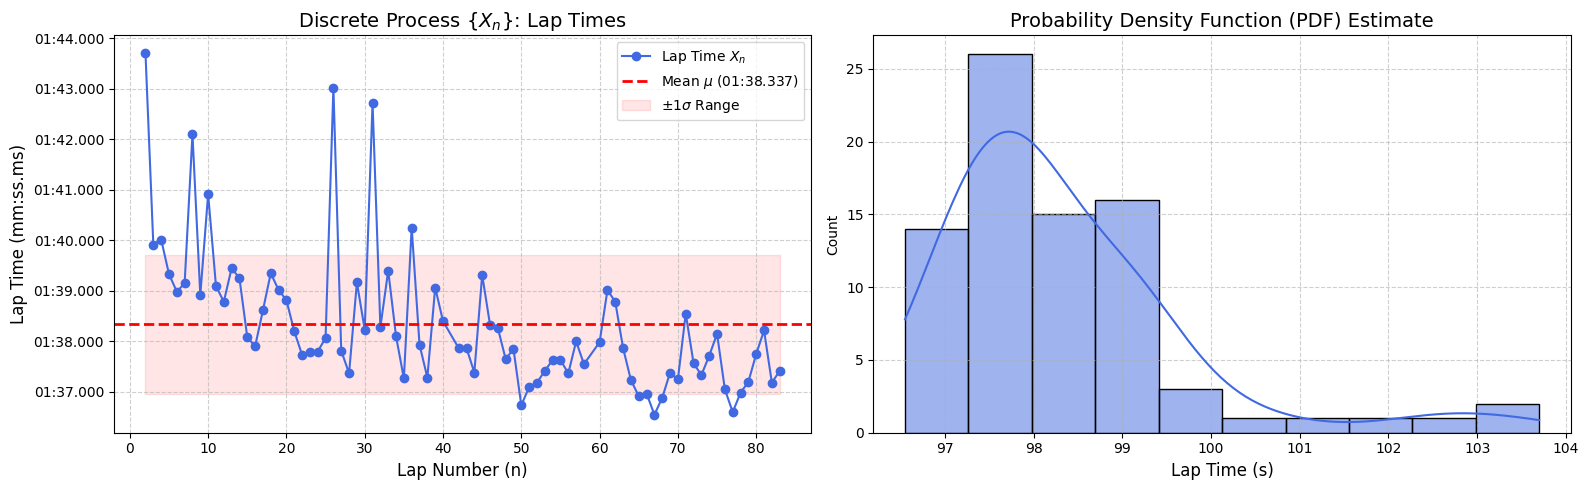

[RESULTS] Discrete Process {X_n} Statistics:
   - Mean (E[X]): 98.3375 s (01:38.337)
   - Std Dev (sigma): 1.3781 s


In [36]:

# Ensure we are working with the clean dataframe
max_lap = df_selected[COL_LAP].max()
df_analysis = df_selected[(df_selected[COL_LAP] > 0) & (df_selected[COL_LAP] < max_lap)].copy() 

print(f"[INFO] Analyzing Laps: {df_analysis[COL_LAP].unique()}")

# 1. Prepare Data: Calculate 'LocalLapTime'
df_analysis['LapStartTime'] = df_analysis.groupby(COL_LAP)[COL_TIME].transform('min')
df_analysis['LocalLapTime'] = df_analysis[COL_TIME] - df_analysis['LapStartTime']

# --- Execution ---
analyze_discrete_stationarity(df_analysis, COL_LAP, COL_TIME)

## 2.2 Análise ciclo-estacionária das principais variáveis

### 2.2.1 - Posição do Pedal do Acelerador (%)

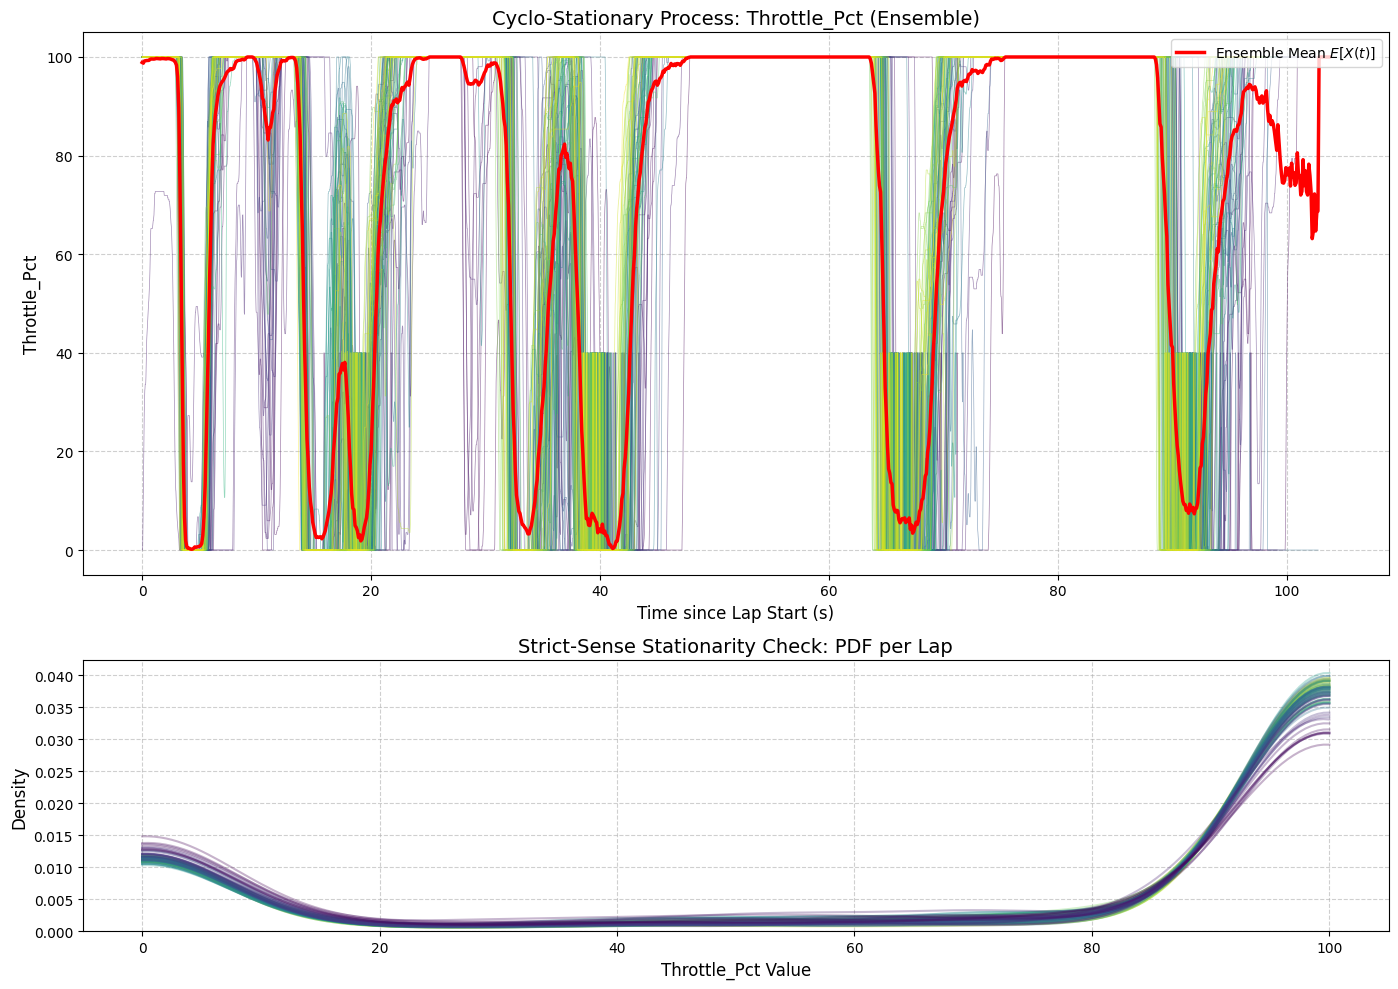

In [22]:
#Análise de Cicloestacionariedade - Pedal do acelerador
COL_VAR = 'Throttle_Pct'
analyze_cyclostationarity(df_analysis, COL_VAR, clip_range=(0, 100))

### 2.2.2 Posição do pedal de freio (%)

[FILTER] Removing values <= 1.0 to analyze active usage shape...


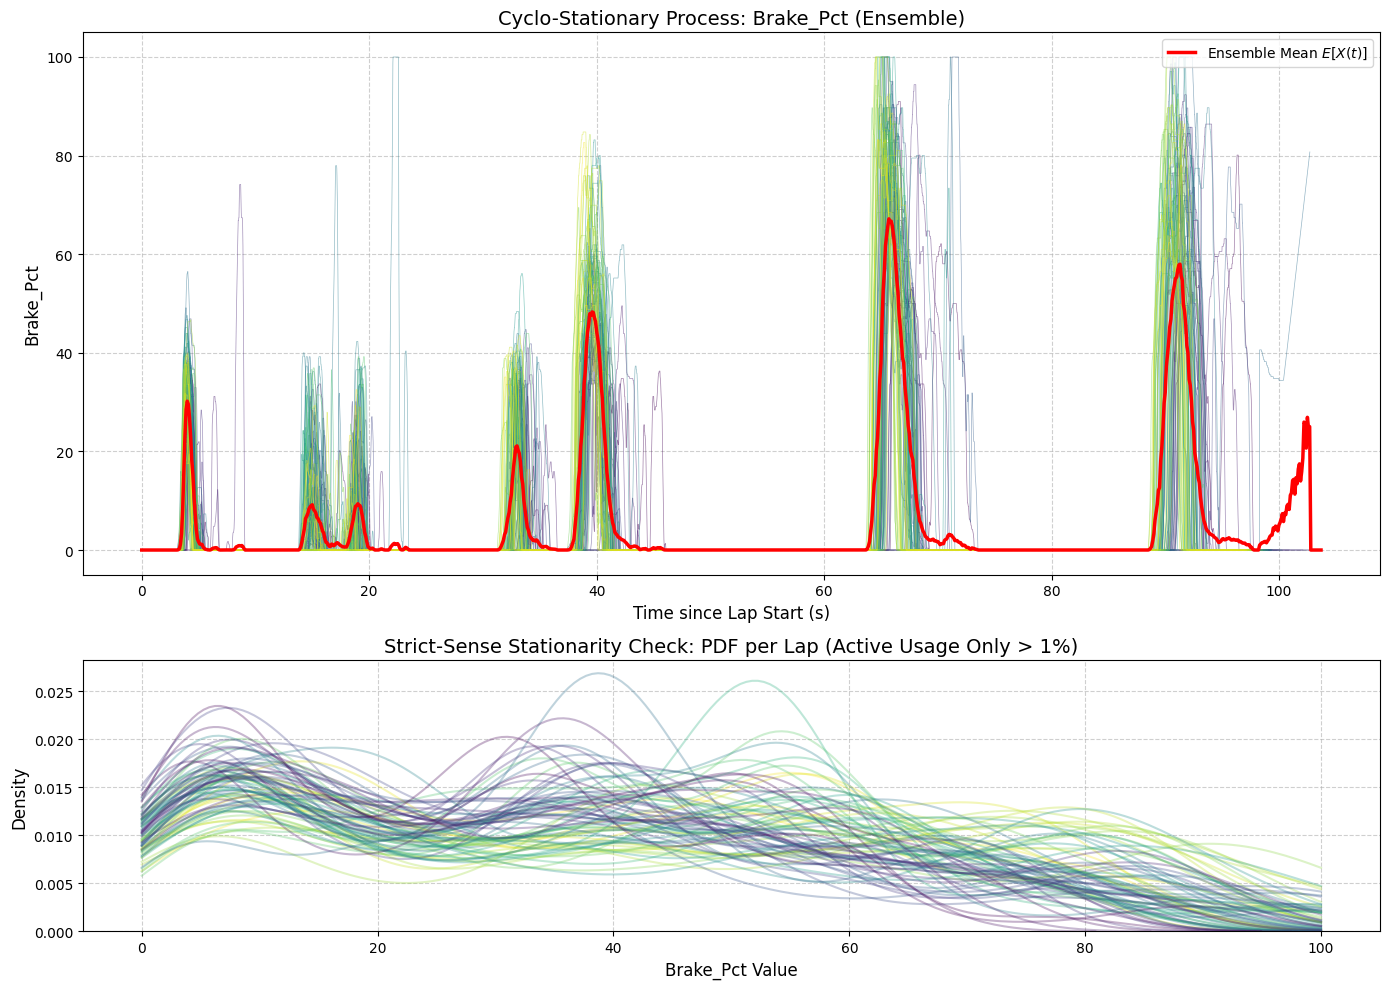

In [24]:
COL_VAR = 'Brake_Pct'
analyze_cyclostationarity(df_analysis, COL_VAR, filter_zeros=True,clip_range=(0, 100))  

### 2.2.3 - Velocidade (km/h)

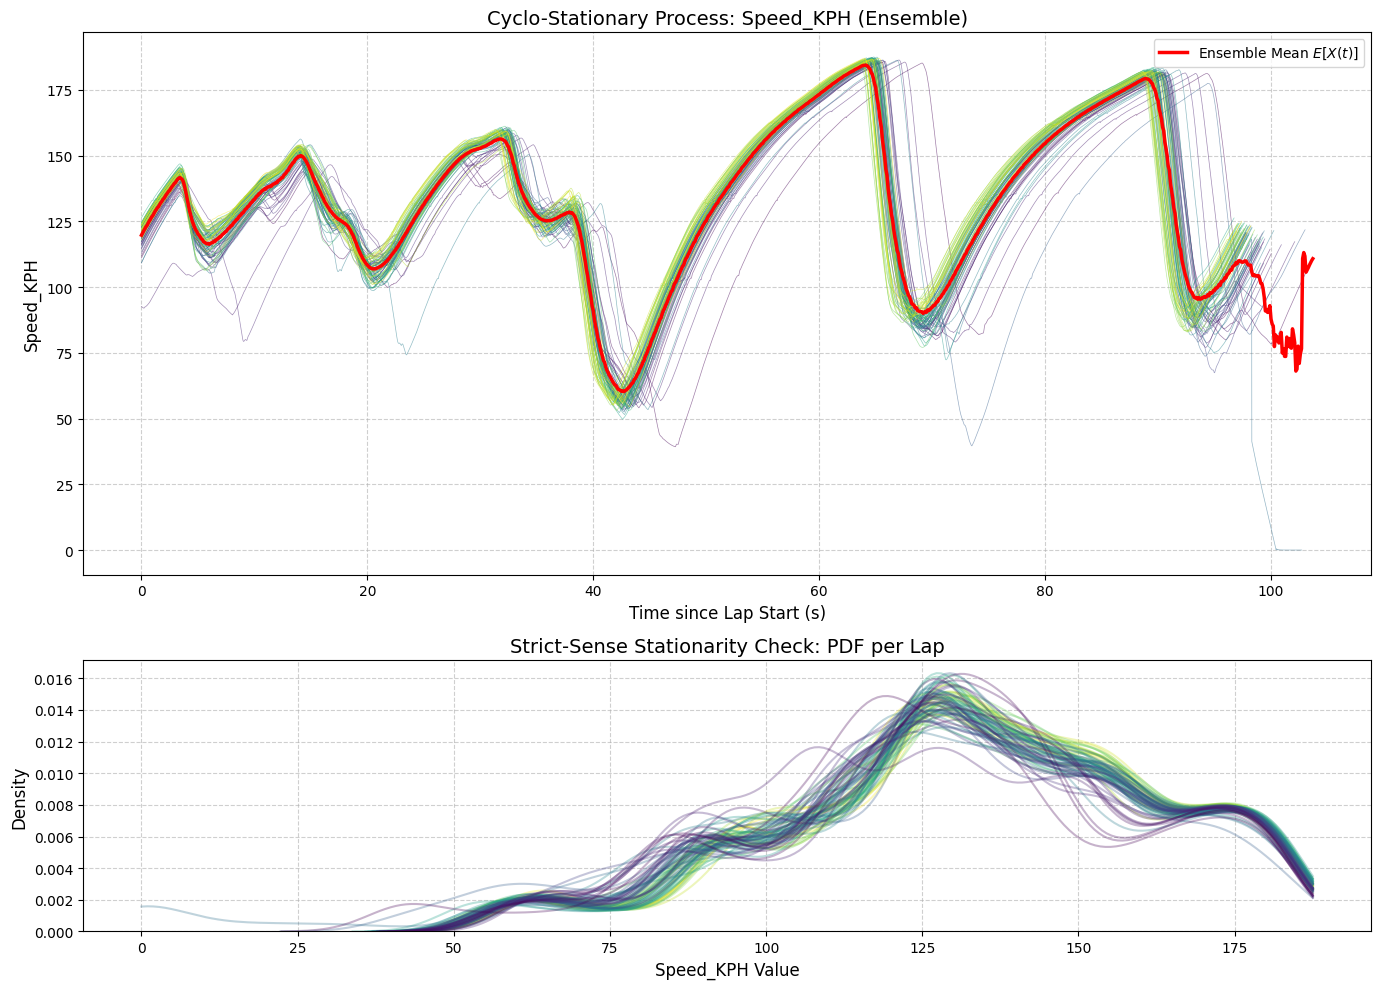

In [26]:
COL_VAR = 'Speed_KPH'
analyze_cyclostationarity(df_analysis, COL_VAR, clip_range=(0, max(df_analysis[COL_VAR])))

### Acelerações Logitudinais e Laterais

Estão disponíveis no dataset de corrida os valores de acelerações longitudinais (eixo x do carro) e laterais (eixo y). Os valores máximos de acelerações estão limitados dentro do chamado círculo G-G que é função da dinâmica veícular do veículos. Alguns fatores são pertinentes para suportar maiores forças G's:

* Tipo de pneu
* Arquitetura de suspensão
* peso do veículo

Para calcularmos a "aceleração geral" do veículo, será utilizado a soma vetorial das duas componentes, sendo assim:

$Acc = \sqrt{A_x^2 + A_y^2}$

In [37]:
from matplotlib.colors import LogNorm


def analyze_gg_dynamics(df, lat_col='LatAccel_G', long_col='LongAccel_G', total_col='TotalAccel_G'):
    """
    Visualizes the Tire Friction Circle (G-G Diagram) and Total G-Force Distribution.
    Assumes input columns are already converted to G units.
    """
    # Safety Check: Verify if columns exist
    missing_cols = [c for c in [lat_col, long_col, total_col] if c not in df.columns]
    if missing_cols:
        print(f"[ERROR] Missing columns: {missing_cols}")
        print("Please run the updated 'basic_clean_and_units' function first.")
        return

    # --- PLOTTING ---
    fig = plt.figure(figsize=(18, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2])

    # --- PLOT 1: The G-G Diagram (Friction Circle) ---
    ax1 = fig.add_subplot(gs[0])
    
    # Hexbin plot for density
    hb = ax1.hexbin(df[lat_col], df[long_col], gridsize=50, 
                    cmap='inferno', mincnt=1, norm=LogNorm())
    
    # Reference Circles
    circle1 = plt.Circle((0, 0), 1.0, color='white', fill=False, linestyle='--', alpha=0.5, label='1.0 G')
    circle2 = plt.Circle((0, 0), 1.5, color='cyan', fill=False, linestyle=':', alpha=0.5, label='1.5 G')
    ax1.add_patch(circle1)
    ax1.add_patch(circle2)
    
    ax1.set_title('G-G Diagram (Friction Circle)', fontsize=16)
    ax1.set_xlabel('Lateral G', fontsize=12)
    ax1.set_ylabel('Longitudinal G', fontsize=12)
    ax1.axhline(0, color='gray', linestyle='-', alpha=0.3)
    ax1.axvline(0, color='gray', linestyle='-', alpha=0.3)
    ax1.axis('equal') 
    ax1.legend(loc='upper right')
    cb = fig.colorbar(hb, ax=ax1)
    cb.set_label('Density (Log Scale)')

    # --- PLOT 2: Distribution of Total Force ---
    ax2 = fig.add_subplot(gs[1])
    
    # Histogram using the pre-calculated total column
    sns.histplot(df[total_col], bins=50, kde=True, ax=ax2, 
                 color='crimson', stat='density')
    
    # Mark Max G (99.9th percentile)
    max_g = df[total_col].quantile(0.999)
    ax2.axvline(max_g, color='black', linestyle='--', label=f'Peak Grip (~{max_g:.2f} G)')
    
    ax2.set_title(r'Distribution of Total Tire Load ($Acc = \sqrt{A_x^2 + A_y^2}$)', fontsize=16)
    ax2.set_xlabel('Combined Acceleration (G)', fontsize=12)
    ax2.set_ylabel('Probability Density', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

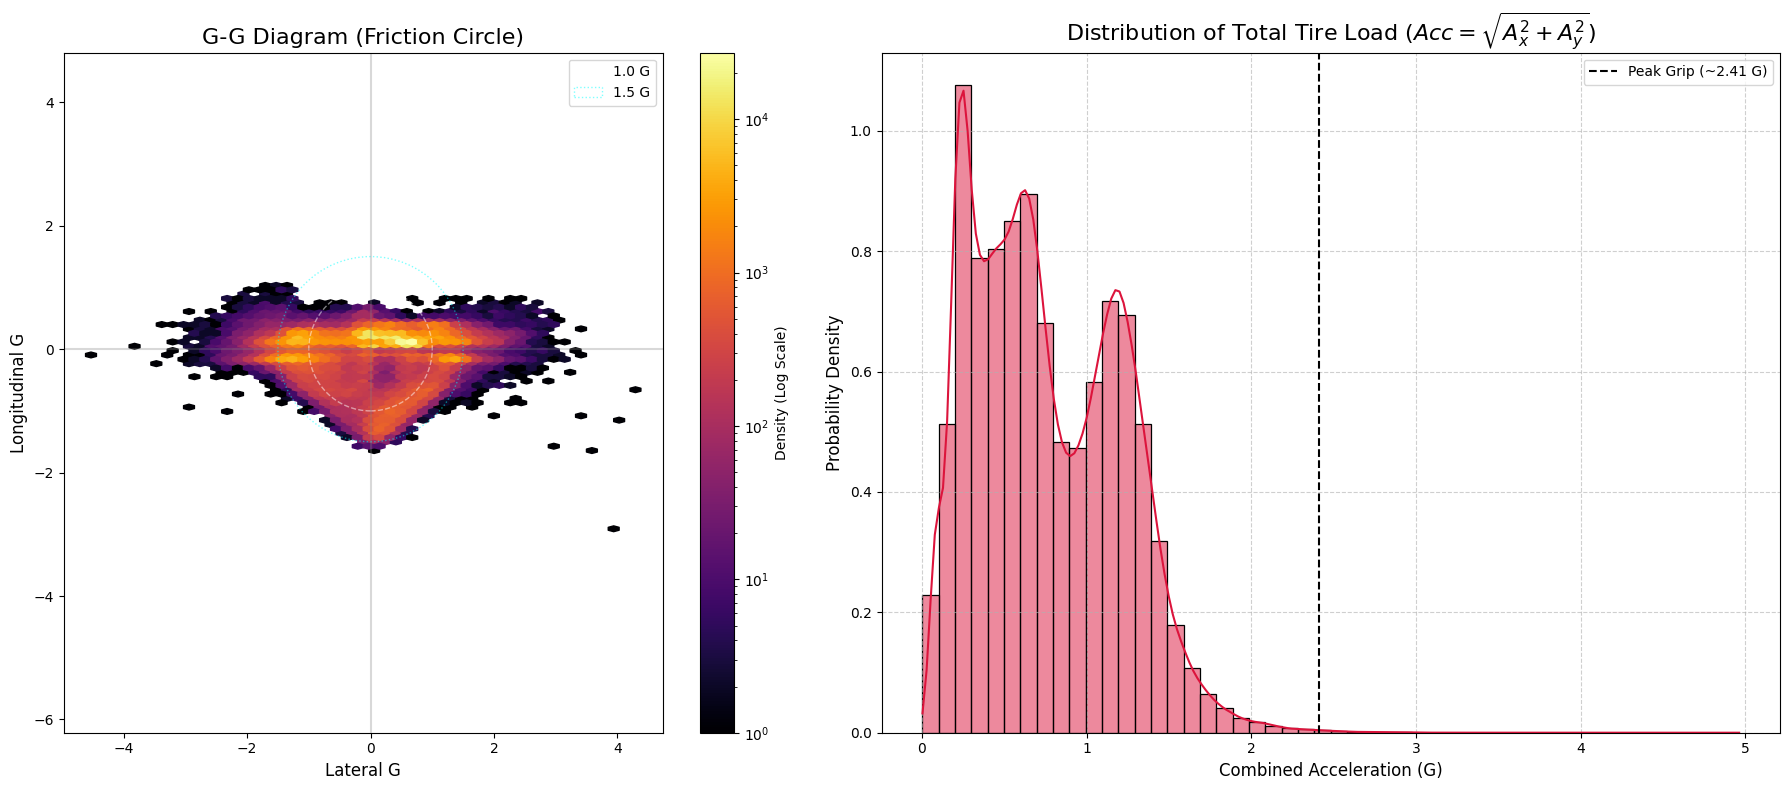

In [40]:
analyze_gg_dynamics(df_analysis)

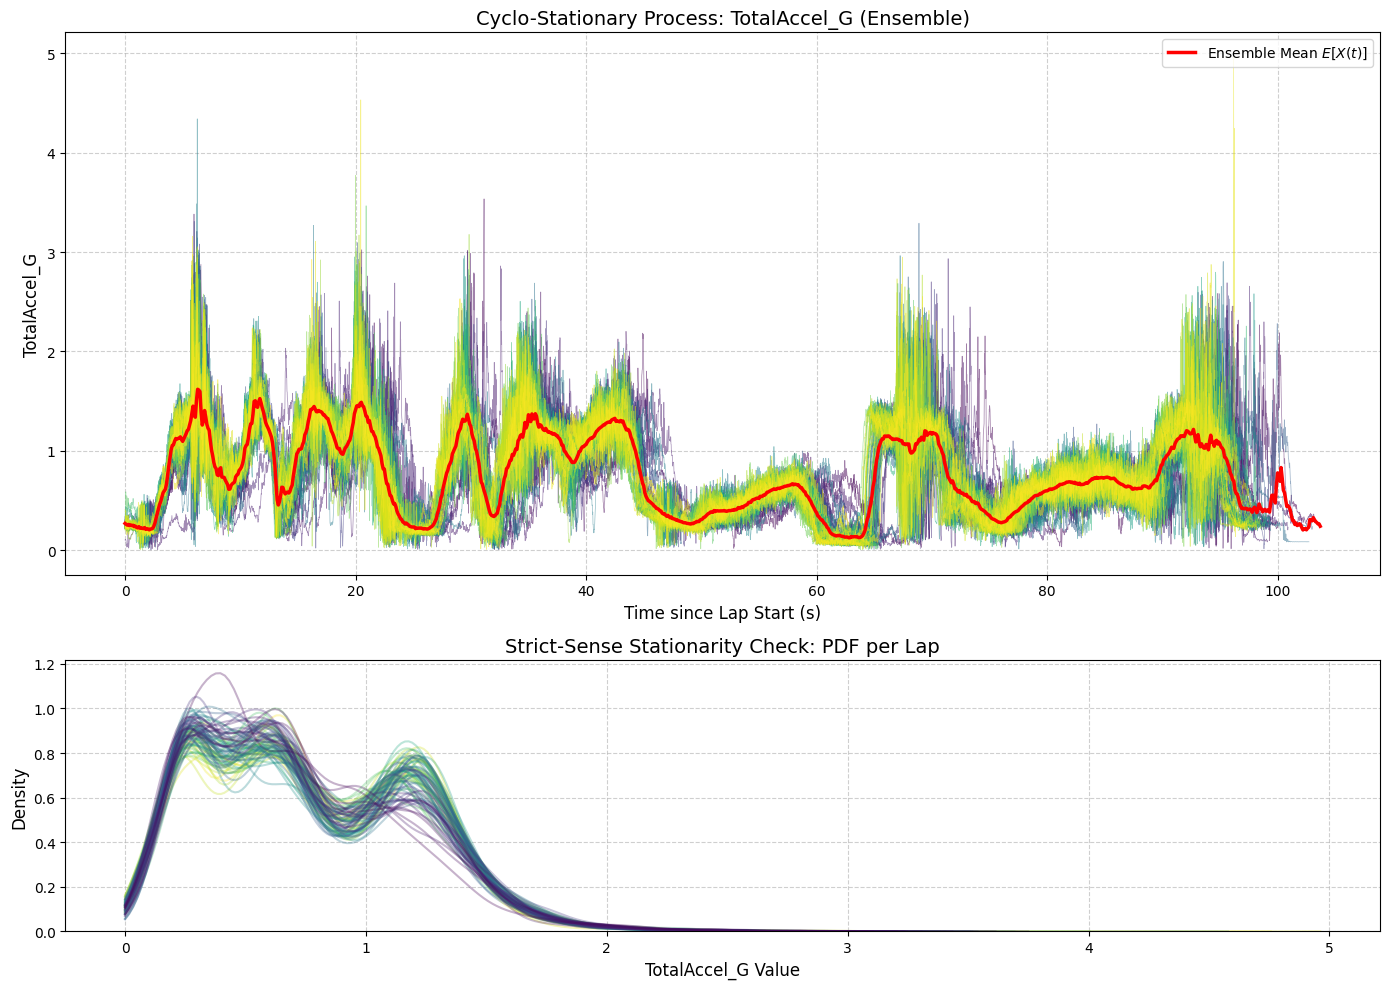

In [41]:
COL_VAR = 'TotalAccel_G'
analyze_cyclostationarity(df_analysis, COL_VAR, clip_range=(0, max(df_selected[COL_VAR])))

## Autocorrelação

[INFO] Calculating Lap Durations from 'SessionTime'...
[INFO] Sample Lap Times (First 5):
Lap
2    103.700000
3     99.916667
4    100.016667
5     99.333333
6     98.983333
Name: SessionTime, dtype: float64


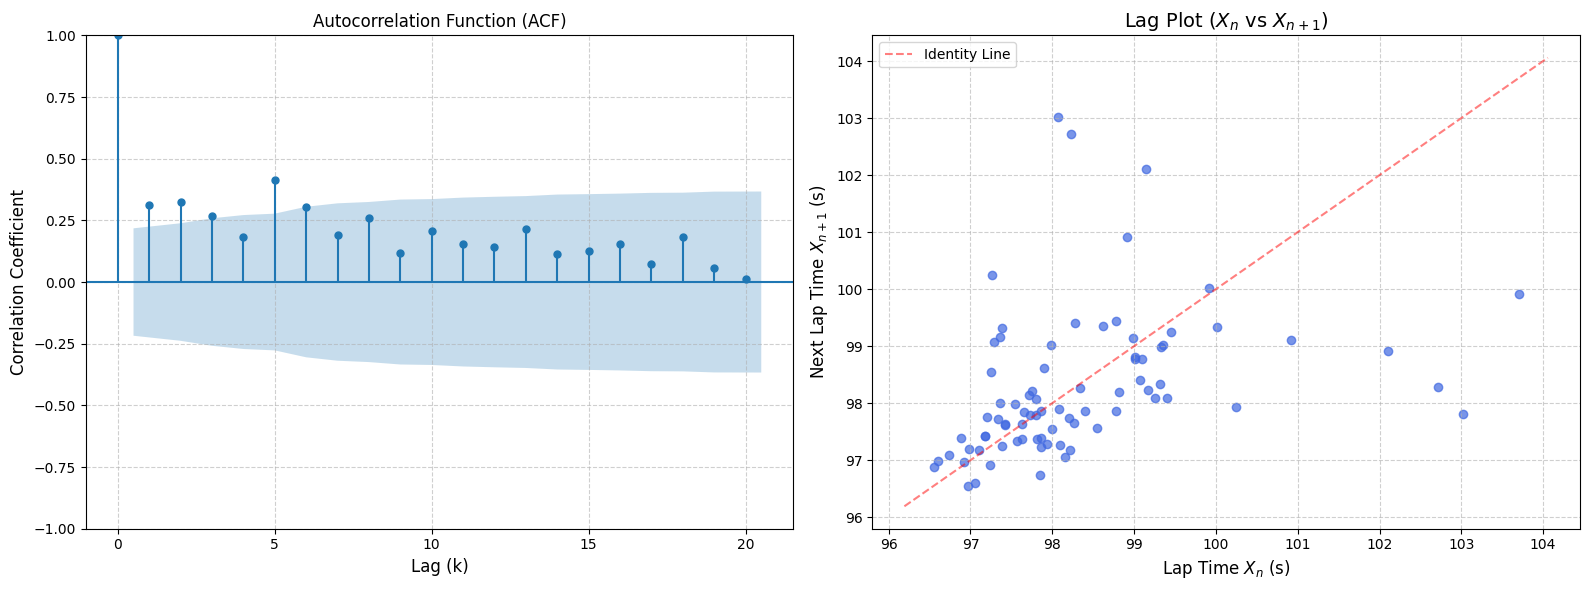

In [16]:
def analyze_lap_autocorrelation(df, lap_col, time_col):
    """
    Analyzes the dependency between consecutive laps (Autocorrelation).
    Calculates lap duration directly from SessionTime.
    """
    print(f"[INFO] Calculating Lap Durations from '{time_col}'...")
    
    # 1. Calculate Lap Durations (X_n)
    # Logic: Duration = End Time - Start Time for each Lap ID
    # This works whether SessionTime is cumulative or resets.
    lap_durations = df.groupby(lap_col)[time_col].apply(lambda x: x.max() - x.min())
    
    # Sanity print to ensure values look like lap times (e.g. 90s) and not timestamps
    print(f"[INFO] Sample Lap Times (First 5):")
    print(lap_durations.head())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- CHART 1: Autocorrelation Function (ACF) ---
    # Shows if Lap n is correlated with Lap n-1, n-2, etc.
    plot_acf(lap_durations, ax=ax1, lags=20, alpha=0.05, title='Autocorrelation Function (ACF)')
    ax1.set_xlabel('Lag (k)', fontsize=12)
    ax1.set_ylabel('Correlation Coefficient', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # --- CHART 2: Lag Plot (Scatter: Lap n vs Lap n+1) ---
    # Visual check for randomness
    lag_plot(lap_durations, lag=1, ax=ax2, c='royalblue', alpha=0.7)
    
    ax2.set_title(r'Lag Plot ($X_n$ vs $X_{n+1}$)', fontsize=14)
    ax2.set_xlabel(r'Lap Time $X_n$ (s)', fontsize=12)
    ax2.set_ylabel(r'Next Lap Time $X_{n+1}$ (s)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    # Identity Line for visual reference
    min_val, max_val = ax2.get_xlim()
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Identity Line')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# --- Execution ---
# Using 'SessionTime' as requested
analyze_lap_autocorrelation(df_selected, COL_LAP, COL_TIME)

# Resultados

## Estacionaridade no sentido amplo

O Gráfico acima representa toda as realizações das voltas a respeito da varíavel "pedal do acelerador (%)".

Alguns insights podem ser gerados a partir dele:

* Para cada linha colorida, é uma volta individual dada na pista de Charlotte. Elas representam a aleatoriedade. Nota-se que elas nunca são idênticas, de modo que em alguns lugares elas se sobrepõem perfeitamente (nas retas), e em outros elas se espalham (nas curvas).

* A Linha vermelha (**$E[X(t)$)**: Esta é a Média do conjunto.Matematicamente, para cada instante de tempo $t$ (por exemplo, aos 10 segundos da volta), o código pegou o valor do acelerador de todas as **80 voltas** e calculou a média. Ela representa o "comportamento esperado" do sistema. 

* Não-Estacionário: através da análise da média em vermelho,depende do tempo $t$, o processo não é estacionário.  Analisando outro por outro viés, se o processo fosse Estacionário (WSS), a linha vermelha seria uma reta horizontal (constante).

* 

## 